- 囲碁の棋譜データの利用
- そのデータでDNNによる着手予測
- 強力なボットの作成，実験，評価

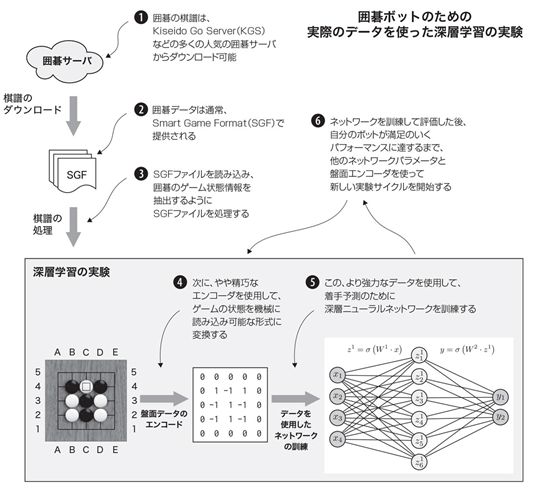

## 囲碁の棋譜のインポート
MCTSで作成した棋譜データは，それを上回る強さのbotを作れない  
強い人間の実際の棋譜データを使うことでbotを大幅に強化

### Smart Game Format(SGF) ファイル
囲碁などのボドゲを表現するメタデータと着手からなるテキストフォーマット  

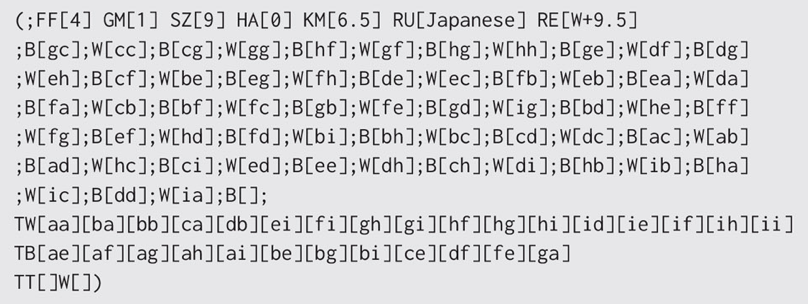
SGFはセミコロンで区切られたノードのリスト
- メタデータはアルファベット2文字と値からなる.
    - FF[4]: SGFのバージョン
    - GM[1]: ゲームが囲碁(インデックス1)
    - SZ[9]: 盤面サイズ9\*9
    - HA[0]: ハンデなし
    - KM[6.5]: 黒が先手でコミが6目半
    - RU[Japanese]: 日本ルール
    - RE[W+9.5]: 結果は白の9目半勝ち
- 着手
    - B[gc]: 7行3列への黒の着手
    - W[cc]: 3行3列への白の着手
    - B[]: 黒がパス
- テリトリーインジケーター: 白のパスで終了するのでそれと同じノードに記述
    - TW, TB: 白と黒のゲーム終了時に持っている領土数
    - TT: どちらも領土として持っていない場所？

### KGSから囲碁の棋譜をダウンロード
https://u-go.net/gamerecords/ の棋譜データを使う  
dlgo/data/を作成し，\_\_init\_\_.pyと
[index_processor.py](https://github.com/maxpumperla/deep_learning_and_the_game_of_go/blob/master/code/dlgo/data/index_processor.py)を作成  
\_\_main\_\_のKGSIndex()にdata_directory="path/to/save"を記入  
``` bash
$ python dlgo/data/index_processor.py
```
ここでやってるのはurllibを使ったスクレイピングとダウンロード

## 深層学習のための囲碁データの準備
SGFファイルを処理するパースロジックを隠蔽したgosgfモジュールを持ってくる  
dlgo/gosgf/を作成し，\_\_init\_\_.pyと次のファイルを作成
- [sgf.py](https://github.com/maxpumperla/deep_learning_and_the_game_of_go/blob/master/code/dlgo/gosgf/sgf.py)
- [sgf_grammar.py](https://github.com/maxpumperla/deep_learning_and_the_game_of_go/blob/master/code/dlgo/gosgf/sgf_grammar.py)
- [sgf_properties.py](https://github.com/maxpumperla/deep_learning_and_the_game_of_go/blob/master/code/dlgo/gosgf/sgf_properties.py)  

このモジュールを使い，SGFの囲碁対局データを再生する

In [1]:
from dlgo.gosgf.sgf import Sgf_game
from dlgo.goboard_fast import GameState, Move
from dlgo.gotypes import Point
from dlgo.utils import print_board
from IPython.display import clear_output
import time

In [4]:
# データを用意
sgf_content = "(;FF[4];B[gc];W[cc];B[cg];W[gg];B[hf])"

# 棋譜データのパース
sgf_game = Sgf_game.from_string(sgf_content)

# 対局開始
game_state = GameState.new_game(19)
for item in sgf_game.main_sequence_iter():
    
    # 着手の内容を取得
    color, move_tuple = item.get_move()
    
    # 着手が打石であるならゲームを進める
    if color is not None and move_tuple is not None:
        row, col = move_tuple
        point = Point(row+1, col+1)
        move = Move.play(point)
        game_state = game_state.apply_move(move)
        clear_output()
        print_board(game_state.board)
        time.sleep(2)

19 +++++++++++++++++++
18 +++++++++++++++++++
17 ++o+++x++++++++++++
16 +++++++++++++++++++
15 +++++++++++++++++++
14 +++++++x+++++++++++
13 ++x+++o++++++++++++
12 +++++++++++++++++++
11 +++++++++++++++++++
10 +++++++++++++++++++
 9 +++++++++++++++++++
 8 +++++++++++++++++++
 7 +++++++++++++++++++
 6 +++++++++++++++++++
 5 +++++++++++++++++++
 4 +++++++++++++++++++
 3 +++++++++++++++++++
 2 +++++++++++++++++++
 1 +++++++++++++++++++
    ABCDEFGHIJKLMNOPQRS


### 囲碁データプロセッサの構築
SGFデータを特徴量とラベルに変換するデータプロセッサを構築  
dlgo/data/に以下を作成  
- [sampling.py](https://github.com/maxpumperla/deep_learning_and_the_game_of_go/blob/master/code/dlgo/data/sampling.py)
- processor.py

- processor.GoDataProcessor    
    - load_go_data: 棋譜データを読み込む親玉
    - unzip_data: .tar.gzを.tarファイルに解凍
    - process_zip; .tar.gzファイルを解凍し再生，1024の着手ごとにf,lを保存
    - num_total_examples: .tar.gzファイルで必要となる棋譜の総数を取得
    - get_handicap: sgfファイルの初期ハンディキャップを適用した盤を返す
    - consolidate_games: process_zipで保存したデータをロードしまとめ返す

GoDataProcessorのテスト

In [ ]:
from dlgo.data.processor import GoDataProcessor
processor = GoDataProcessor()
features, labels = processor.load_go_data('train', 100)
clear_output()

### 効率的なデータ読込のためも囲碁データジェネレータの構築
一度にデータを読み込むとout-of-memory exceptionになるので，yieldできるようにする  
dlgo/data/にgenerator.pyを作成
- generator.DataGenerator
    - get_num_samples: サンプルの総数を取得
    - generate: yieldによってミニバッチを取得
    - \_generate: GoDataProcessor.consolidate_gamesのyield版

### 並列囲碁データ処理およびジェネレータ
さらに，KGSファイルを特徴量とラベルに変換する処理を並列化する．  
[parallel_processor.py](https://github.com/maxpumperla/deep_learning_and_the_game_of_go/blob/master/code/dlgo/data/parallel_processor.py)を参考に作成

In [4]:
from dlgo.data.parallel_processor import ParallelGoDataProcessor
processor = ParallelGoDataProcessor(encoder='oneplane')
generator = processor.load_go_data('train', 100)
clear_output()
print(f"num samples: {generator.get_num_samples()}")
generator = generator.generate(batch_size=10)
X, y = generator.__next__()
print(f"X shape: {X.shape}, y shape: {y.shape}")

num samples: 11264
X shape: (10, 1, 19, 19), y shape: (10, 361)


1のところはencoderが複数持つ盤面データ．channelに相当  
このように，NCWHという順序にすることをchannel firstと言い，慣習になっている  
この慣習はConv2DやZeroPadding2Dなどの層でdata_format='channels_first'と指定できる

## 人間の対局データによる深層学習モデルの訓練
[dlgo/networks](https://github.com/maxpumperla/deep_learning_and_the_game_of_go/tree/master/code/dlgo/networks)
を作成し，その中にベースラインを作っていく


畳み込み層4つと全結合層，そして出力層にソフトマックス，それぞれにReLUを行う  
さらに，各畳み込み層の前にはZeroPadding2Dを使用

small.pyを作成

In [3]:
from dlgo.data.parallel_processor import ParallelGoDataProcessor
from dlgo.encoders.oneplane import OnePlaneEncoder
from dlgo.networks import small
from keras.models import Sequential
from keras.layers.core import Dense
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


データをもらうためのgeneratorを用意

In [4]:
go_board_rows, go_board_cols = 19, 19
num_classes = go_board_rows * go_board_cols
num_games = 100

encoder = OnePlaneEncoder((go_board_rows, go_board_cols))
processor = ParallelGoDataProcessor(encoder=encoder.name())

generator = processor.load_go_data('train', num_games)
test_generator = processor.load_go_data('test', num_games)
clear_output()

モデルをもらってきてコンパイル

In [ ]:
input_shape = (encoder.num_planes, go_board_rows, go_board_cols)

model = Sequential()
for layer in small.layers(input_shape):
    model.add(layer)
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])